In [1]:
import numpy as np, matplotlib.pyplot as plt
import matelms as me
from krypy.linsys import LinearSystem, Gmres

In [2]:
b, eta = 1.0, 0.1
xij,yij,zij = np.array([-2.0040735703833774, 0., 0.])

In [3]:
bla = np.arange(-2.5,6.5,0.01)
G   = np.zeros(bla.shape[0])
j=0
for i in bla:
    G[j]=np.linalg.norm(me.hatGHH(xij+i,yij,zij, b,eta))
    j+=1

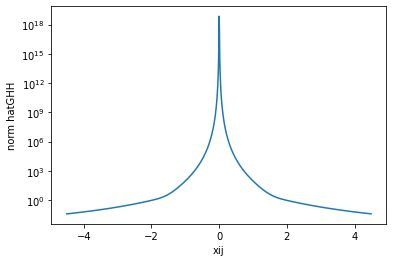

In [4]:
plt.semilogy(xij+bla, G)
plt.xlabel('xij')
plt.ylabel('norm hatGHH')
plt.show()

In [5]:
A = me.hatGHH(xij,yij,zij, b,eta)
rhs = np.array([-3.61793170e-02,  2.59142196e-02,  1.77068227e-11,  6.54652400e-02,
        4.70402394e-11, -3.23106866e-12,  3.83713453e-12, -6.67357620e-03,
        3.47068296e-12, -6.33144584e-03, -2.04419091e-02, -1.23737976e-02,
        5.45695828e-12,  7.06117263e-03,  3.50955094e-12,  1.03926109e-02,
       -5.40151097e-13])

In [6]:
bla = np.arange(-2.5,6.5,0.01)
FH  = np.zeros(bla.shape[0])
j=0
for i in bla:
    invGHH = np.linalg.pinv(me.hatGHH(xij+i,yij,zij, b,eta), rcond=1e-5)
    FH[j]=np.linalg.norm(np.dot(invGHH, rhs))
    j+=1

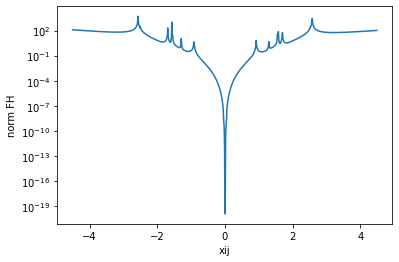

In [7]:
plt.semilogy(xij+bla, FH)
plt.xlabel('xij')
plt.ylabel('norm FH')
plt.show()

In [8]:
np.linalg.solve(me.hatGHH(xij,yij,zij, b,eta), rhs)

array([ 2.74603905e+00,  1.19484324e+00,  5.65198015e-10,  4.34042793e+00,
        6.56526274e-09, -2.33534737e-10, -3.11904800e-10,  8.18389505e-01,
       -4.83476670e-10, -3.60643522e-02,  7.77534082e-01,  1.79976617e+00,
        4.88528694e-10,  2.67542801e+00,  3.76886275e-09,  2.35096280e+00,
        1.65532330e-09])

In [9]:
VH = np.array([ 4.21309891e-02,  5.38249051e-02,  2.29117550e-11, -1.02130989e-01,
       -6.90146223e-11,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [10]:
## zeroth order guess for FH from VH on same particle
PI = 3.14159265359

g2s = np.full(5, 4*PI*eta*b)
#g3t = np.full(3, 0.8*PI*eta*b)
gH  = np.diag(np.block([g2s,np.zeros(12)]))

FH0 = np.dot(-gH,VH)



In [11]:
FH0

array([-5.29433623e-02, -6.76383706e-02, -2.87917605e-11,  1.28341586e-01,
        8.67263322e-11,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [12]:
linear_system = LinearSystem(A, rhs)
solver = Gmres(linear_system, maxiter=None, tol=1e-5, x0=FH0)

In [13]:
solver

krypy GMRES object
    MMlr0 = [[-0.04549868], ..., [-5.40151097e-13]]
    MMlr0_norm = 0.09331955688083769
    MlAMr: 17 x 17 matrix
    Mlr0: [[-0.04549868], ..., [-5.40151097e-13]]
    R: 18 x 17 matrix
    V: 17 x 18 matrix
    flat_vecs: True
    store_arnoldi: False
    ortho: mgs
    tol: 1e-05
    maxiter: 17
    iter: 9
    explicit residual: False
    resnorms: [1.1090891563249858, ..., 5.702010103535793e-06]
    x0: [[-0.05294336], ..., [0.]]
    xk: [[2.74603905], ..., [-2.06057921e-07]]

In [14]:
solver.resnorms ##with FH0 guess

[1.1090891563249858,
 1.1051260142588044,
 0.8991212712933273,
 0.8480614081740967,
 0.8130339600130604,
 0.8128315286895992,
 0.7743668516673894,
 0.3292321507191613,
 0.030270751815754286,
 0.008446996586743378,
 5.702010103535793e-06]

In [15]:
bla = np.arange(-2.5,6.5,0.01)
FH  = np.zeros(bla.shape[0])
solverList=[]
linearList=[]

j=0
for i in bla:
    linearList.append(LinearSystem(me.hatGHH(xij+i,yij,zij, b,eta), rhs))
    solverList.append(Gmres(linearList[j], tol=1e-5,maxiter=None))
    FH[j] = np.linalg.norm(solverList[j].xk)
    j+=1

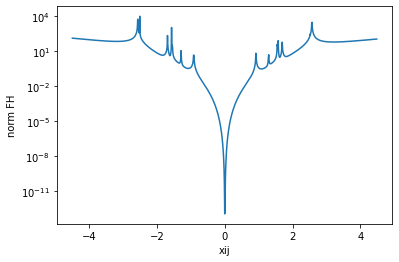

In [16]:
plt.semilogy(xij+bla, FH)
plt.xlabel('xij')
plt.ylabel('norm FH')
plt.show()

In [17]:
from scipy.sparse.linalg import gmres, bicgstab

In [18]:
bla = np.arange(-2.5,6.5,0.01)
FH  = np.zeros(bla.shape[0])
solverList=[]
linearList=[]

j=0
for i in bla:
    sol = gmres(me.hatGHH(xij+i,yij,zij, b,eta), rhs, x0=None,
                restart=10, maxiter=10)
    FH[j] = np.linalg.norm(sol[0])
    j+=1

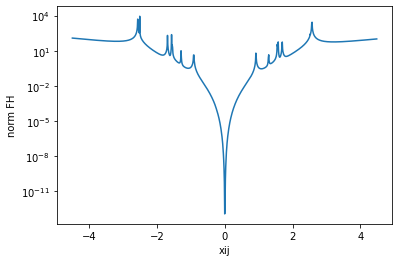

In [19]:
plt.semilogy(xij+bla, FH)
plt.xlabel('xij')
plt.ylabel('norm FH')
plt.show()

In [20]:
sol = bicgstab(A, rhs, x0=None,  maxiter=3)
sol[0]

array([-5.81626410e+00, -9.74568164e+00, -6.13475107e-09, -1.28772832e+01,
       -5.76214038e-09,  1.63836981e-07,  1.01740295e-09, -5.73298269e+00,
       -8.68601434e-08, -9.27997235e+00, -1.72212856e+00,  3.14694861e+00,
       -1.93927728e-09, -1.36981595e+00,  1.19455084e-08, -3.73341754e-02,
        5.69574950e-10])

In [29]:
bla = np.arange(-2.5,6.5,0.01)
FH  = np.zeros(bla.shape[0])
solverList=[]
linearList=[]

j=0
for i in bla:
    sol = bicgstab(me.hatGHH(xij+i,yij,zij, b,eta), rhs, maxiter=12)
    FH[j] = np.linalg.norm(sol[0])
    j+=1

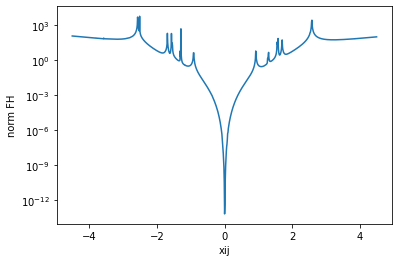

In [30]:
plt.semilogy(xij+bla, FH)
plt.xlabel('xij')
plt.ylabel('norm FH')
plt.show()

In [31]:
minIndex = np.where(FH[:]==np.amax(FH[:]))
xij+bla[minIndex]

array([-2.51407357])

In [24]:
FH_real = np.linalg.solve(me.hatGHH(xij,yij,zij, b,eta), rhs)
normFH = np.linalg.norm(FH_real)

In [27]:
iterations = np.arange(0,20)
normList = []
resList = []

j=0
for i in iterations:
    sol = bicgstab(me.hatGHH(xij,yij,zij, b,eta), rhs, maxiter=i+1)
    normList.append(np.linalg.norm(sol[0]))
    resList.append(np.linalg.norm((rhs-np.dot(me.hatGHH(xij,yij,zij, b,eta), sol[0]))))
    j+=1

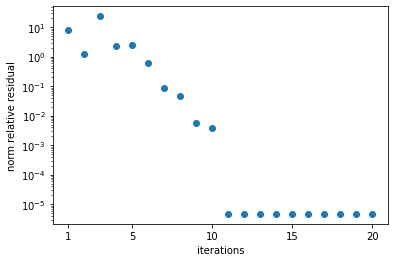

In [28]:
plt.semilogy(iterations+1, resList/np.linalg.norm(rhs), 'o')
plt.ylabel('norm relative residual')
plt.xlabel('iterations')
plt.xticks((1, 5, 10, 15, 20))
plt.show()

In [37]:
def dd(X):
    D = np.diag(np.abs(X)) # Find diagonal coefficients
    S = np.sum(np.abs(X), axis=1) - D # Find row sum without diagonal
    if np.all(D > S):
        print('matrix is diagonally dominant')
    else:
        print('NOT diagonally dominant')
    return


In [39]:
np.diag(np.abs(A))

array([0.07957501, 0.01507088, 0.01507088, 0.00512401, 0.01476975,
       0.39385994, 0.19692997, 0.19692997, 0.14769748, 0.04923249,
       0.35423133, 0.11147234, 0.11147234, 0.03437176, 0.01145725,
       0.01238394, 0.00247679])

In [41]:
np.sum(np.abs(A),axis=1) - np.diag(np.abs(A))

array([0.2527592 , 0.12423349, 0.12162672, 0.15579887, 0.05625151,
       0.19692997, 0.45570139, 0.57878262, 0.39401036, 0.19708039,
       0.17711567, 0.16565841, 0.1427439 , 0.16070484, 0.08205416,
       0.13283675, 0.04427892])

In [43]:
1/g2s

array([0.79577472, 0.79577472, 0.79577472, 0.79577472, 0.79577472])